## Srijesh_Reddy AA 5750 Homework Week 7 - HW7 - Jupyter Notebook
### **Our goal is to implement THREE LeNet Convolutional Neural Network models and compare their results. Then, report the results in a markdown table within this Jupyter Notebook.**

---

## Put your *answer table* <em>here</em> filling out these items (it should look somewhat like this):
<img src="images/table.png" width="650">

### To edit and create your markdown table, double click this markdown cell. Hint - How to do tables in markdown:

| Model     |     Run Time     |Training Data Accuracy| Test Data Accuracy |
|-----------|------------------|----------------------|--------------------|
|not_lenet  |2.1586472829182943|87.00%                |88.39 %             |
|-----------|------------------|----------------------|--------------------|
|lenet_small|2.2492052515347800|97.00%                |98.22 %             |
|-----------|------------------|----------------------|--------------------|
|lenet_big  |6.8875518321990965|98.00%                |98.73% |
|-----------|------------------|----------------------|--------------------|

### <font color='red'> Your solution code will go in cells below.  Execute and read this WHOLE Notebook....

---

# Setup

In [1]:
 # Prevent some warning messages from displaying
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# Load TensorFlow and surpress some non-error messages
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [3]:
import numpy as np
#import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR) # This hides some warning messages
#tf.logging.set_verbosity(tf.logging.INFO)

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
tf.get_logger().setLevel('ERROR')

import matplotlib.pyplot as plt

import helpers_05

%matplotlib inline

print(tf.__version__)

2.9.1


# Convolutions

In order to give our model more spatial awareness, provide translation invariance, and reduce the amount of parameters in our network, we need to share weights in such a way that the same pixels located in different parts of a image output identical activation values. The technique we end up using is called a _convolution_.

![](images/convolution_animated.gif)

The defining feature of a convolution is the _kernel_ (also known as a _filter_), which is a grid-like set of weights which slides over regions of an input image. At each step, the kernel weights are multiplied with the corresponding pixel values underneath. These multiplied values are then summed to get the output value at that point.

![](images/convolution_still.png)

By performing the operation in this way, we can use local spatial information while also making sure that each part of the image can be examined with the same weights.

This is something that is easier to learn visually, so let's take a look at a simple example:

![](images/basic_kernel_anim.gif)

Here, we have a 5x5 input matrix, and our kernel is 3x3. When the kernel is placed in the top-left portion of the input, we end up with the following total sum:

```
(1 * -1) + (2 * 1) + (0 * 2) + (1 * 1) + (0 * 1) + (0 * 0) + (2 * -1)+ (2 * 0) = -2
```

We can see that the value of `-2` is the top-left entry in our output matrix. As we slide the kernel across the image, we get corresponding outputs which follow the kernel spatially. 

---

# LeNet Overview

**Convolutional Neural Networks** are a special kind of multi-layer neural network. Like almost every other neural network, they are trained to learn an output. Where they differ is in their architecture. **Convolutional Neural Networks** are designed to recognize visual patterns directly from pixel images with minimal preprocessing. They can recognize patterns with extreme variability (such as handwritten characters), and with robustness to distortions and simple geometric transformations.  
<br>
This Notebook describes in more detail the architecture of **LeNet**, a Convolutional Neural Network architecture used in this Notebook. LeNet comprises **7 layers**, not counting the input, all of which contain trainable parameters (weights). The input is a 32x32 pixel image of handwritten numerals. The output is the numeral.
<br>

#### **Our goal now is to implement THREE LeNet Convolutional Neural Networks and compare their results.**

<br>
For more information on LeNet, see: http://yann.lecun.com/exdb/lenet/

In [4]:
# We're going to make use a few names that we defined in helper files
# they've been gathered in helpers_05.py
from helpers_05 import (batches, flatten, fully_connected_layer,
                        fully_connected_sigmoid_layer,
                        test_and_show_images)

## Convolution Layers

---


In [5]:
def conv_layer(incoming, num_kernels, kernel_sz, 
               strides=[1, 1, 1, 1], padding='SAME',
               bval=0.01, 
               activation_fn=tf.nn.relu, 
               name=None):
    prev_outshape = incoming.shape.dims[-1].value
    kshape = kernel_sz + [prev_outshape, num_kernels]

    fan_in = np.prod(incoming.shape[1:]).value
    xavier_stddev = np.sqrt(2.0 / fan_in)
    
    with tf.variable_scope(name, 'conv_layer'):
        w = tf.Variable(tf.truncated_normal(kshape, stddev=xavier_stddev), name='kernel')
        b = tf.Variable(tf.constant(bval, shape=[num_kernels]), name='bias')
        conv = tf.nn.conv2d(incoming, w, strides, padding, name='conv')
        z = tf.nn.bias_add(conv, b)
        return z if activation_fn is None else activation_fn(z)

In [6]:
def pool_layer(incoming, ksize, strides=None, padding='VALID',
               pool_fn=tf.nn.max_pool, name=None):
    'create a pooling layer:  we auto-add the leading/trailing 1s'
    ksize = [1] + ksize + [1]
    # default strides to ksize
    strides = strides if strides is not None else ksize
    with tf.variable_scope(name, 'pool_layer'):
        return pool_fn(incoming, ksize, strides, padding)

## LeNet Sub-Networks

To get us **warmed up**, here is a simple network that shares some of the architecture of LeNet, but it is smaller and it uses sigmoid activations.

In [7]:
def not_lenet(images):
    with tf.name_scope('not_lenet'):     # small model
        conv_1 = conv_layer(images, 6, [5, 5])
        pool_1 = pool_layer(conv_1, [2, 2])
        conv_2 = conv_layer(pool_1, 16, [5, 5])
        pool_2 = pool_layer(conv_2, [2, 2])
        
        flat = flatten(pool_2)
        
        fc_layer = fully_connected_sigmoid_layer
        fc_1 = fc_layer(flat, 120)
        fc_2 = fc_layer(fc_1,  84)
        fc_3 = fully_connected_layer(fc_2,  10, w_stddev = 0.5, activation_fn=None)
    
    return fc_3 

**Xavier initialization**  It isn't that hard to implement, either.  Here, we simply add a value to compute `w_stddev` instead of setting it to a fixed constant (see line 8 in the next cell).

In [8]:
def fully_connected_xavier_relu_layer(incoming_layer, num_nodes,
                                      b_val=0.01,
                                      keep_prob=None, name=None):
    ' pass through for fully_connected_layer with xavier init '
    incoming_layer = tf.convert_to_tensor(incoming_layer)
    prev_num_nodes = incoming_layer.shape.dims[-1].value
    
    w_stddev = np.sqrt(2.0 / prev_num_nodes)

    return fully_connected_layer(incoming_layer, num_nodes,
                                 w_stddev = w_stddev, b_val=b_val,
                                 activation_fn = tf.nn.relu,
                                 keep_prob=keep_prob,
                                 name=name)


<br>

<br>

##### With the above as a starting point, we can now recrete that actual LeNet.  Here's the table from the slides:

![](images/lenet-table.png)

and the graphic from the paper (http://yann.lecun.com/exdb/publis/psgz/lecun-98.ps.gz):

![](images/lenet.png)

Unfortunately, you have to combine information from the table and the graphic to get the numbers below.  The depths come from the graphic (they precede the `@` signs on the top of the figure).  The other values come from the table.

##### What follows are two architectures for LeNet
##### A small verion of LeNet:

In [9]:
def lenet_small(images):
    with tf.name_scope('small_lenet_model'):    
        conv_1 = conv_layer(images, 6, [5, 5])
        pool_1 = pool_layer(conv_1, [2, 2])
        conv_2 = conv_layer(pool_1, 16, [5, 5])
        pool_2 = pool_layer(conv_2, [2, 2])

        flat = flatten(pool_2)

        fc_layer = fully_connected_xavier_relu_layer
        fc_1   = fc_layer(flat, 120)
        fc_2   = fc_layer(fc_1, 84)
        fc_3   = fc_layer(fc_2, 10)
        fc_4   = fully_connected_layer(fc_3, 10, activation_fn=None)
    
    return fc_4

##### And here's a scaled up LeNet:

In [10]:
def lenet_big(images):
    with tf.name_scope('big_lenet_model'):    
        conv_1 = conv_layer(images, 32, [5, 5])
        pool_1 = pool_layer(conv_1, [2, 2])
        conv_2 = conv_layer(pool_1, 64, [5, 5])
        pool_2 = pool_layer(conv_2, [2, 2])

        flat = flatten(pool_2)

        fc_layer = fully_connected_xavier_relu_layer
        fc_1   = fc_layer(flat, 400)
        fc_2   = fc_layer(fc_1, 200)
        fc_3   = fc_layer(fc_2, 200)
        fc_4   = fully_connected_layer(fc_3, 10, activation_fn=None)
    
    return fc_4

---
# AA 5750 Homework 

You mission is to take the pieces I've developed and turn them into a working model for **LeNet CNN** on the MNIST dataset.  Here's a process used to get started:

  1.  Grab your MNIST model.
  2.  Modify it so that your s.out is coming from one of the LeNet versions we defined above.
  4.  Read in your training and testing data with `helpers_05.get_mnist_dataset` 
  5.  Setup a training loop.  Note, use a `learning_rate=0.001` and we don't need a `momentum`.
  6.  If things are working right, you shouldn't need 15 epochs of training.  Five or six should do.
  7.  Consult the solution below for **not_lenet**, then do the same for the **lenet_small** and **lenet_big**

## Solution (common code section)

In [11]:
class MNIST_Conv_Model(object):
    def __init__(s, lenet_function):  # non-standard, for abbreviation
        graph = tf.Graph()
        with graph.as_default():
            with tf.name_scope('inputs'):
                s.images = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name="x")
                s.labels = tf.placeholder(tf.int32, shape=[None])

            with tf.name_scope('hyperparams'):
                s.learning_rate = tf.placeholder(tf.float32, name='learning_rate')                
            
            # HUMMMMM:  why floating for one-hot?
            s.one_hot_labels = tf.one_hot(s.labels, 10, dtype=tf.float32) 
            
            # main LeNet component
            # this is setup so the user passes in one of the lenet functions defined above
            # (note, they pass in the function -not- the results of calling that function;
            #  we take care of calling it here)
            s.logits = lenet_function(s.images)
            
            with tf.name_scope('loss'):
                smce = tf.nn.softmax_cross_entropy_with_logits
                s.loss = tf.reduce_mean(smce(logits=s.logits, labels=s.one_hot_labels),
                                             name="loss")

            with tf.name_scope('global_step'):
                global_step = tf.Variable(0, trainable=False, name='global_step')
                s.inc_step = tf.assign_add(global_step, 1, name='inc_step')

            with tf.name_scope('train'):
                decayed_rate = tf.train.exponential_decay(s.learning_rate, global_step,
                                                          600, 0.998, True)
                momopt = tf.train.MomentumOptimizer
                s.train = momopt(decayed_rate, 0.9).minimize(s.loss)
            
            with tf.name_scope('prediction'):
                s.softmax    = tf.nn.softmax(s.logits, name="softmax")
                s.prediction = tf.cast(tf.arg_max(s.softmax, 1), tf.int32)
                
                s.pred_correct  = tf.equal(s.labels, s.prediction)
                s.pred_accuracy = tf.reduce_mean(tf.cast(s.pred_correct, tf.float32))    
            s.init = tf.global_variables_initializer()
            
        s.session = tf.Session(graph=graph)
        writer = tf.summary.FileWriter('./tensorboard', s.session.graph)   ############################## TB
        s.session.run(s.init)
    
    def fit(s, train_dict):
        tr_loss, step, tr_acc, _ = s.session.run([s.loss, s.inc_step, s.pred_accuracy, 
                                                  s.train], 
                                              feed_dict=train_dict)
        return tr_loss, step, tr_acc
    
    def predict(s, test_dict):
        ct_correct, preds = s.session.run([s.pred_correct, s.prediction], 
                                          feed_dict=test_dict)
        return ct_correct, preds

In [12]:
(train_data, train_labels, 
 test_data, test_labels) = helpers_05.get_mnist_dataset()

In [13]:
train_data.shape

(60000, 28, 28, 1)

---

---

---

# STEP 1

## Run the cell below to get results for the "not_lenet" LeNet CNN model
## Then, copy cells to run for models of "lenet_small" and then for "lenet_big"
## Enter your results in a TABLE at the top of this Notebook
## Return your Notebook with your results for submission on Canvas

In [14]:
# Train your model
# Run this cell to train "not_lenet", then copy it to a new cell (see below) and run on the other LeNet models
# Hint: You only need to change ONE line of code to change the model!!!
#      
import time

model_to_use = not_lenet     # or lenet_small or not_lenet or lenet_big
epochs = 7

start = time.time()
mm = MNIST_Conv_Model(model_to_use)
starte = time.time()
for epoch in range(epochs):
    for batch_data, batch_labels in batches(train_data, train_labels, 100):
        train_dict = {mm.images : batch_data, 
                      mm.labels : batch_labels, 
                      mm.learning_rate : 0.001} # , # 1e-3
        tr_loss, step, tr_acc = mm.fit(train_dict)
    info_update = "Epoch: {:2d} Step: {:5d} Loss: {:6.2f} Acc: {:5.2f}%      Epoch Time: {:8.2f} Seconds"
    print(info_update.format(epoch, step, tr_loss, tr_acc*100.0, time.time()-starte))
    starte = time.time()

end = time.time()
print("Run Time: ", (end - start)/60.0, "minutes")

2022-12-10 17:43:22.003948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 17:43:22.045297: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch:  0 Step:   600 Loss:   0.98 Acc: 80.00%      Epoch Time:    18.40 Seconds
Epoch:  1 Step:  1200 Loss:   0.71 Acc: 81.00%      Epoch Time:    18.49 Seconds
Epoch:  2 Step:  1800 Loss:   0.47 Acc: 91.00%      Epoch Time:    18.59 Seconds
Epoch:  3 Step:  2400 Loss:   0.71 Acc: 81.00%      Epoch Time:    17.96 Seconds
Epoch:  4 Step:  3000 Loss:   0.37 Acc: 93.00%      Epoch Time:    18.27 Seconds
Epoch:  5 Step:  3600 Loss:   0.34 Acc: 94.00%      Epoch Time:    17.85 Seconds
Epoch:  6 Step:  4200 Loss:   0.47 Acc: 87.00%      Epoch Time:    19.59 Seconds
Run Time:  2.1586472829182943 minutes


In [15]:
# Test Data Accuracy
# Run this cell too on each of your models
#
batch_correct_cts = []
for batch_data, batch_labels in batches(test_data, test_labels, 200):
    test_dict = {mm.images : batch_data, 
                 mm.labels : batch_labels}
    correctness, curr_preds = mm.predict(test_dict)
    batch_correct_cts.append(correctness.sum())

print("Test Data Accuracy: ",sum(batch_correct_cts) / len(test_data)*100,"%")

Test Data Accuracy:  88.39 %


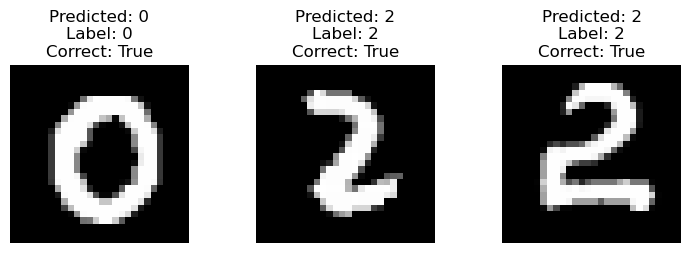

In [16]:
# Run this once, you don't need to copy and run this cell (unless you want to) on the other models

indices = [0, 25, 9999]
test_dict = {mm.images : test_data[indices],
             mm.labels : test_labels[indices]}
test_and_show_images(mm, test_dict, 
                     test_data[indices], test_labels[indices])

In [17]:
# Run this once, you don't need to copy and run this cell (unless you want to) on the other models

correctness = []
for batch_data, batch_labels in batches(test_data, test_labels, 200):
    test_dict = {mm.images : batch_data,
                 mm.labels : batch_labels}
    curr_correctness, curr_preds = mm.predict(test_dict)
    correctness.extend(curr_correctness)
incorrect = np.where(np.logical_not(np.array(correctness, dtype=np.bool)))[0]

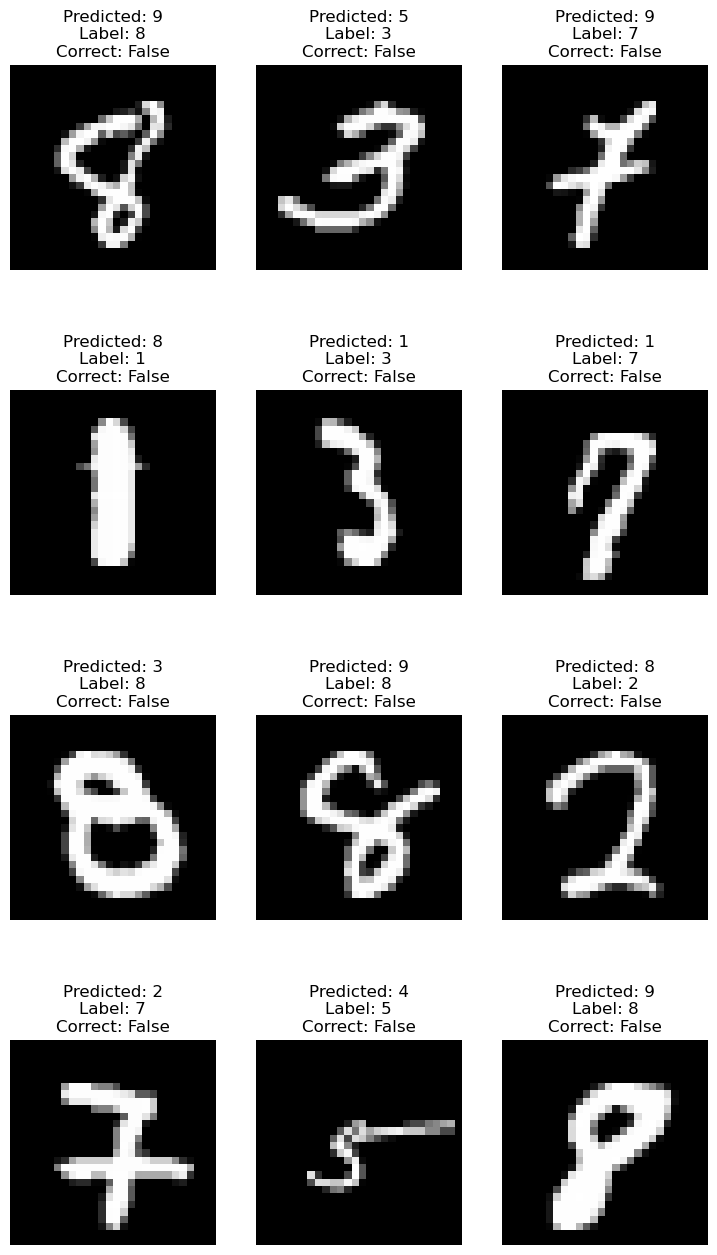

In [18]:
# Run this once, you don't need to copy and run this cell (unless you want to) on the other models

indices = incorrect[:12]
test_dict = {mm.images : test_data[indices],
             mm.labels : test_labels[indices]}
test_and_show_images(mm, test_dict,
                     test_data[indices], test_labels[indices])

---

# STEP 2

##### Now copy appropriate code cells from above, and change to <ins>lenet_small</ins>, run to train it, and get timing, training and test accuracies

In [19]:
import time

model_to_use = lenet_small     # or lenet_small or not_lenet or lenet_big
epochs = 7

start = time.time()
mm = MNIST_Conv_Model(model_to_use)
starte = time.time()
for epoch in range(epochs):
    for batch_data, batch_labels in batches(train_data, train_labels, 100):
        train_dict = {mm.images : batch_data, 
                      mm.labels : batch_labels, 
                      mm.learning_rate : 0.001} # , # 1e-3
        tr_loss, step, tr_acc = mm.fit(train_dict)
    info_update = "Epoch: {:2d} Step: {:5d} Loss: {:6.2f} Acc: {:5.2f}%      Epoch Time: {:8.2f} Seconds"
    print(info_update.format(epoch, step, tr_loss, tr_acc*100.0, time.time()-starte))
    starte = time.time()

end = time.time()
print("Run Time: ", (end - start)/60.0, "minutes")

Epoch:  0 Step:   600 Loss:   0.18 Acc: 97.00%      Epoch Time:    17.73 Seconds
Epoch:  1 Step:  1200 Loss:   0.15 Acc: 95.00%      Epoch Time:    19.92 Seconds
Epoch:  2 Step:  1800 Loss:   0.04 Acc: 99.00%      Epoch Time:    19.65 Seconds
Epoch:  3 Step:  2400 Loss:   0.09 Acc: 97.00%      Epoch Time:    19.19 Seconds
Epoch:  4 Step:  3000 Loss:   0.12 Acc: 95.00%      Epoch Time:    19.41 Seconds
Epoch:  5 Step:  3600 Loss:   0.08 Acc: 97.00%      Epoch Time:    20.71 Seconds
Epoch:  6 Step:  4200 Loss:   0.10 Acc: 97.00%      Epoch Time:    18.07 Seconds
Run Time:  2.24920525153478 minutes


In [20]:
batch_correct_cts = []
for batch_data, batch_labels in batches(test_data, test_labels, 200):
    test_dict = {mm.images : batch_data, 
                 mm.labels : batch_labels}
    correctness, curr_preds = mm.predict(test_dict)
    batch_correct_cts.append(correctness.sum())

print("Test Data Accuracy: ",sum(batch_correct_cts) / len(test_data)*100,"%")

Test Data Accuracy:  98.22 %


---

# STEP 3

##### Now copy appropriate code cells from above, and change to <ins>lenet_big</ins>, run to train it, and get timing, training and test accuracies

In [21]:
import time

model_to_use = lenet_big     # or lenet_small or not_lenet or lenet_big
epochs = 7

start = time.time()
mm = MNIST_Conv_Model(model_to_use)
starte = time.time()
for epoch in range(epochs):
    for batch_data, batch_labels in batches(train_data, train_labels, 100):
        train_dict = {mm.images : batch_data, 
                      mm.labels : batch_labels, 
                      mm.learning_rate : 0.001} # , # 1e-3
        tr_loss, step, tr_acc = mm.fit(train_dict)
    info_update = "Epoch: {:2d} Step: {:5d} Loss: {:6.2f} Acc: {:5.2f}%      Epoch Time: {:8.2f} Seconds"
    print(info_update.format(epoch, step, tr_loss, tr_acc*100.0, time.time()-starte))
    starte = time.time()

end = time.time()
print("Run Time: ", (end - start)/60.0, "minutes")

Epoch:  0 Step:   600 Loss:   0.10 Acc: 97.00%      Epoch Time:    59.98 Seconds
Epoch:  1 Step:  1200 Loss:   0.17 Acc: 92.00%      Epoch Time:    58.81 Seconds
Epoch:  2 Step:  1800 Loss:   0.07 Acc: 99.00%      Epoch Time:    57.09 Seconds
Epoch:  3 Step:  2400 Loss:   0.01 Acc: 100.00%      Epoch Time:    63.68 Seconds
Epoch:  4 Step:  3000 Loss:   0.00 Acc: 100.00%      Epoch Time:    58.42 Seconds
Epoch:  5 Step:  3600 Loss:   0.00 Acc: 100.00%      Epoch Time:    57.78 Seconds
Epoch:  6 Step:  4200 Loss:   0.04 Acc: 98.00%      Epoch Time:    57.17 Seconds
Run Time:  6.8875518321990965 minutes


In [22]:
batch_correct_cts = []
for batch_data, batch_labels in batches(test_data, test_labels, 200):
    test_dict = {mm.images : batch_data, 
                 mm.labels : batch_labels}
    correctness, curr_preds = mm.predict(test_dict)
    batch_correct_cts.append(correctness.sum())

print("Test Data Accuracy: ",sum(batch_correct_cts) / len(test_data)*100,"%")

Test Data Accuracy:  98.72999999999999 %
